In [11]:
# 第 0-1 步：安裝 lifelines（Colab 只要裝一次）
!pip install lifelines

In [12]:
# 第 0-2 步：匯入套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts

# 繪圖風格
plt.style.use("seaborn-v0_8")  # 若有警告可以忽略


In [13]:
# 第 1-1 步：讀取 CSV 檔案
# 若檔案已經在 Colab 左側檔案區：
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Vibe Coding/Data/heart_failure_clinical_records_dataset.csv")

# 若想用手動上傳方式：
# from google.colab import files
# uploaded = files.upload()
# filename = list(uploaded.keys())[0]
# df = pd.read_csv(filename)

# 第 1-2 步：快速檢視資料
display(df.head())
print(df.info())


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB
None


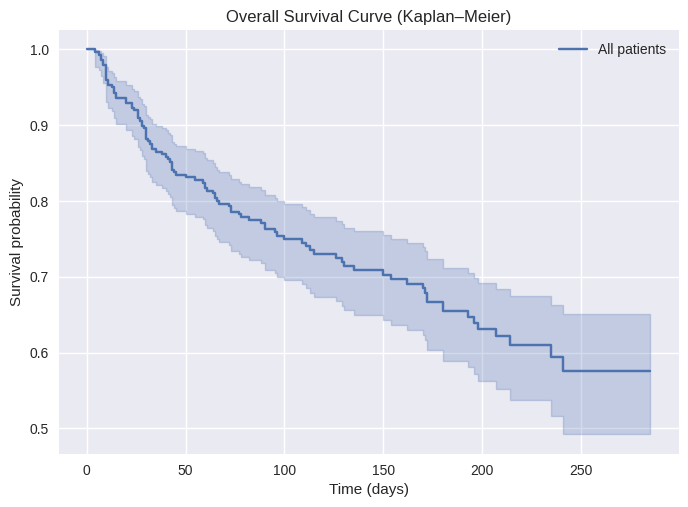

In [14]:
# 第 2-1 步：整體 KM 生存曲線（不分組）

kmf = KaplanMeierFitter()

T = df["time"]          # 存活時間
E = df["DEATH_EVENT"]   # 事件指標（1=死亡）

kmf.fit(T, event_observed=E, label="All patients")

ax = kmf.plot(ci_show=True)
ax.set_title("Overall Survival Curve (Kaplan–Meier)")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Survival probability")
plt.show()


EF 中位數： 38.0


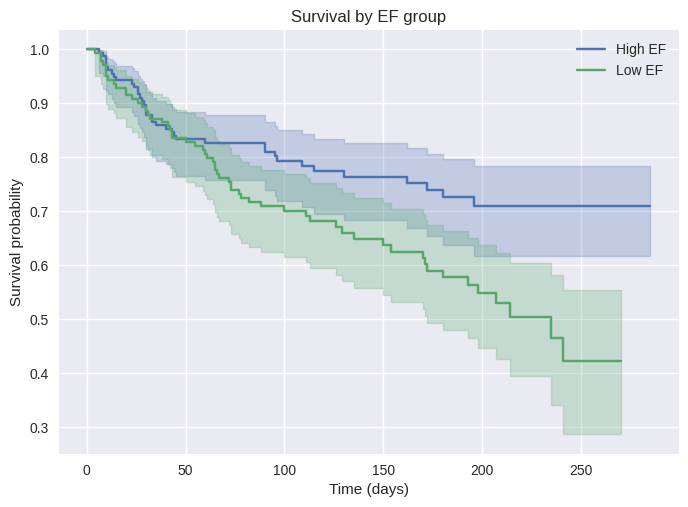

In [15]:
# 第 3-1 步：依 ejection_fraction 分高 / 低兩組

median_ef = df["ejection_fraction"].median()
print("EF 中位數：", median_ef)

df["EF_group"] = np.where(df["ejection_fraction"] >= median_ef, "High EF", "Low EF")

# 第 3-2 步：畫出分組 KM 生存曲線
kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

mask_high = df["EF_group"] == "High EF"
mask_low = df["EF_group"] == "Low EF"

T_high = df.loc[mask_high, "time"]
E_high = df.loc[mask_high, "DEATH_EVENT"]

T_low = df.loc[mask_low, "time"]
E_low = df.loc[mask_low, "DEATH_EVENT"]

ax = plt.subplot(111)

kmf_high.fit(T_high, event_observed=E_high, label="High EF")
kmf_high.plot_survival_function(ax=ax)

kmf_low.fit(T_low, event_observed=E_low, label="Low EF")
kmf_low.plot_survival_function(ax=ax)

ax.set_title("Survival by EF group")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Survival probability")
plt.show()


In [16]:
# 第 4-1 步：準備資料給 Cox 模型

df_cox = df.copy()

# 選擇要放進 Cox 的變數
covariates = [
    "age",
    "ejection_fraction",
    "serum_creatinine",
    "anaemia",
    "diabetes",
    "high_blood_pressure",
    "sex",
    "smoking",
]

# 建立 CoxPHFitter 物件
cph = CoxPHFitter()

# duration_col = time, event_col = DEATH_EVENT
cph.fit(df_cox[["time", "DEATH_EVENT"] + covariates],
        duration_col="time",
        event_col="DEATH_EVENT")

cph.print_summary()   # 類似迴歸結果 summary，包含 HR、p-value 等


<lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
      baseline estimation = breslow
   number of observations = 299
number of events observed = 96
   partial log-likelihood = -471.78
         time fit was run = 2025-12-02 12:27:55 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
age                  0.05      1.05      0.01            0.03            0.06                1.03                1.07
ejection_fraction   -0.05      0.95      0.01           -0.07           -0.03                0.93                0.97
serum_creatinine     0.35      1.42      0.07            0.22            0.48                1.25                1.62
anaemia              0.34      1.40      0.21           -0.07            0.75                0.93                2.11
diabetes             0.17      1.18      0.22           -0.26            0.60                0.77                1.82
high_blood_pressure  0.43      1.53      0.21            0.01            0.85                1.01                2.33
sex                 -0.15      0.86      0.24           -0.63            0.33                0.53                1.39
smoking              0.09      1.09      0.25           -0.40            0.57                0.67                1.78

                     cmp to     z      p  -log2(p)
covariate                                         
age                    0.00  4.90 <0.005     20.00
ejection_fraction      0.00 -5.06 <0.005     21.18
serum_creatinine       0.00  5.25 <0.005     22.64
anaemia                0.00  1.61   0.11      3.22
diabetes               0.00  0.77   0.44      1.19
high_blood_pressure    0.00  1.99   0.05      4.42
sex                    0.00 -0.62   0.53      0.90
smoking                0.00  0.36   0.72      0.47
---
Concordance = 0.73
Partial AIC = 959.55
log-likelihood ratio test = 74.86 on 8 df
-log2(p) of ll-ratio test = 40.79

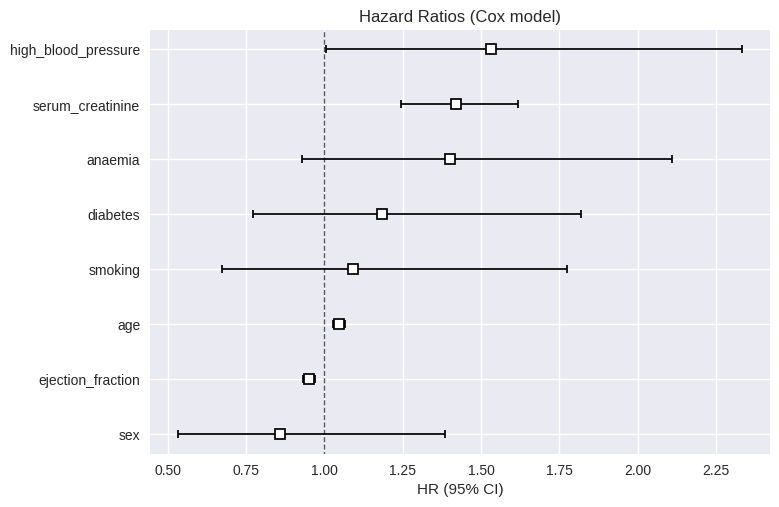

In [17]:
# 第 5-1 步：畫出 hazard ratio（exp(coef)）與信賴區間

ax = cph.plot(hazard_ratios=True)
ax.set_title("Hazard Ratios (Cox model)")
plt.show()


In [18]:
# 第 5-2 步：建立兩種典型病人特徵

# 用整體平均當 baseline
baseline = df_cox[covariates].mean()

low_risk = baseline.copy()
high_risk = baseline.copy()

# 低風險：年輕、EF 高、Creatinine 低、無高血壓、無吸菸
low_risk["age"] = df_cox["age"].quantile(0.25)
low_risk["ejection_fraction"] = df_cox["ejection_fraction"].quantile(0.75)
low_risk["serum_creatinine"] = df_cox["serum_creatinine"].quantile(0.25)
low_risk["high_blood_pressure"] = 0
low_risk["smoking"] = 0

# 高風險：年老、EF 低、Creatinine 高、有高血壓、吸菸
high_risk["age"] = df_cox["age"].quantile(0.75)
high_risk["ejection_fraction"] = df_cox["ejection_fraction"].quantile(0.25)
high_risk["serum_creatinine"] = df_cox["serum_creatinine"].quantile(0.75)
high_risk["high_blood_pressure"] = 1
high_risk["smoking"] = 1

# 轉成 DataFrame（lifelines 需要 2D 結構）
df_profiles = pd.DataFrame([low_risk, high_risk], index=["Low risk", "High risk"])

df_profiles


,age,ejection_fraction,serum_creatinine,anaemia,diabetes,high_blood_pressure,sex,smoking
Low risk,51.0,45.0,0.9,0.431438,0.41806,0.0,0.648829,0.0
High risk,70.0,30.0,1.4,0.431438,0.41806,1.0,0.648829,1.0


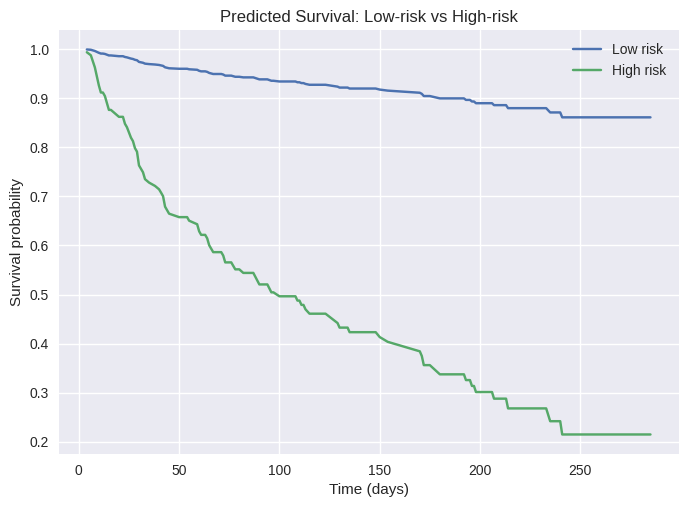

In [19]:
# 第 5-3 步：用 Cox 模型預測生存曲線

surv_funcs = cph.predict_survival_function(df_profiles)

ax = surv_funcs.plot()
ax.set_title("Predicted Survival: Low-risk vs High-risk")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Survival probability")
plt.show()


In [20]:
# 第 6 步（選用）：檢查比例風險假設
# 會輸出文字與圖形提示，有助於確認模型假設是否合理

cph.check_assumptions(df_cox[["time", "DEATH_EVENT"] + covariates], p_value_threshold=0.05)


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 299 total observations, 203 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic    p  -log2(p)
age                 km              0.30 0.59      0.77
                    rank            0.13 0.72      0.47
anaemia             km              0.00 0.95      0.08
                    rank            0.00 0.99      0.01
diabetes            km              0.15 0.70      0.52
                    rank            0.05 0.82      0.29
ejection_fraction   km              4.88 0.03      5.20
                    rank            4.89 0.03      5.21
high_blood_pressure km              0.06 0.81      0.31
                    rank            0.05 0.82      0.28
serum_creatinine    km              2.42 0.12      3.06
                    rank            2.36 0.12      3.01
sex                 km              0.14 0.71      0.50
                    rank            0.41 0.52      0.94
smoking             km              0.47 0.49      1.02
                    rank            0.21 0.64      0.63



1. Variable 'ejection_fraction' failed the non-proportional test: p-value is 0.0271.

   Advice 1: the functional form of the variable 'ejection_fraction' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'ejection_fraction' using pd.cut, and then specify it in
`strata=['ejection_fraction', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Prop

[]